In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web
import random

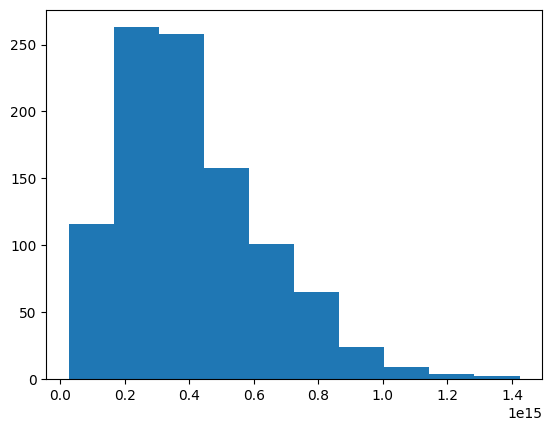

In [2]:
def sample_blackbody_frequencies(T, size=1):
    """
    Sample frequencies (Hz) from the energy-weighted Planck distribution at temperature T (K)
    using rejection sampling with a Gamma(3, θ=2) envelope.
    """
    # Physical constants
    h = 6.62607015e-34     # Planck constant (J·s)
    k = 1.380649e-23       # Boltzmann constant (J/K)

    # Dimensionless normalization constant for the target PDF: p_x(x) = A * x^3 / (e^x - 1)
    A = 15 / np.pi**4      # ensures ∫_0^∞ p_x(x) dx = 1

    # Envelope (Gamma distribution) parameters
    # Envelope PDF: g(x) = x^2 e^{-x/2} / 16, shape=3, scale=2
    # Maximum ratio M = max_x [p_x(x)/g(x)] = 240/π^4
    M = 240 / np.pi**4

    samples = []
    while len(samples) < size:
        # Draw from envelope gamma(k=3, θ=2)
        x = np.random.gamma(shape=3, scale=2)
        # Compute target and envelope densities at x
        f_target = A * x**3 / (np.exp(x) - 1)
        g = (x**2 * np.exp(-x/2)) / 16
        # Accept-reject step
        if np.random.rand() <= f_target / (M * g):
            samples.append(x)

    # Convert dimensionless x to physical frequency ν = (kT/h) x
    x_arr = np.array(samples)
    frequencies = (k * T / h) * x_arr
    return frequencies

def mode_blackbody_frequency(T):
    """
    Return the mode of the energy-weighted Planck PDF (Hz) at temperature T (K).
    """
    h = 6.62607015e-34   # J·s
    k = 1.380649e-23     # J/K
    x_peak = 2.8214393721220787
    return (k * T / h) * x_peak

T = 5000  #Temperature Kelvin
freqs = sample_blackbody_frequencies(T, size=1000)
plt.hist(freqs)

freq_range = (min(freqs),max(freqs))
freq_width = 0.33 * (max(freqs) - min(freqs))
freq0_all = mode_blackbody_frequency(T)
lambda0 = td.constants.C_0/freq0_all

In [3]:
t_slab = 1

# Simulation size and run time
Lx, Ly, Lz = (2, 2, t_slab + 5)
sim_size = (Lx + 5,Ly + 5,Lz)
run_time = 100/np.average(freqs)
print(run_time)

# Grid specification
grid_spec = td.GridSpec.auto(wavelength=lambda0)

2.458531141561685e-13


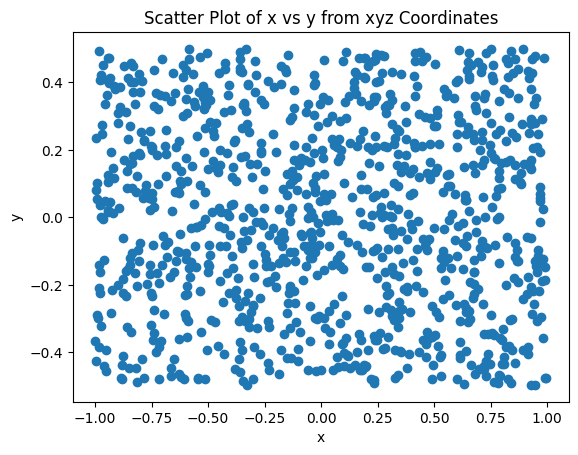

In [4]:
def dipole_source(num_source,freqs):
    sources = []
    locs = []
    for i in range(num_source):
        f = freqs[i]
        pulse = td.GaussianPulse(freq0=f, fwidth=0.1*f)
        # Source definition
        x_coord = np.random.uniform(-Lx/2,Lx/2)
        y_coord = np.random.uniform(-Ly/2,Ly/2)
        z_coord = np.random.uniform(-t_slab/2,t_slab/2)
        polarizations = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
        rand_pol = random.choice(polarizations)
        pt_dipole = td.PointDipole(
          center=(x_coord,y_coord,z_coord),
          source_time=pulse,
          polarization=rand_pol,
          interpolate=True)
        sources.append(pt_dipole)
        locs.append((x_coord,y_coord,z_coord))
    return sources,locs

sources,locs = dipole_source(1000,freqs)

# Extract x and y values
x_vals = [c[0] for c in locs]
y_vals = [c[1] for c in locs]
z_vals = [c[2] for c in locs]

# Create scatter plot of x vs y
plt.scatter(x_vals, z_vals)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter Plot of x vs y from xyz Coordinates")
plt.show()

In [5]:
n_slab = 3.5
mat_slab = td.Medium(permittivity=n_slab**2, name='silicon')

slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(Lx, Ly, t_slab),
    ),
    medium=mat_slab,
    name='slab',
)

In [6]:
monitor_field = td.FieldMonitor(
    center=(0, 0, 0),
    size=(Lx,Ly,t_slab),
    freqs=[freq0_all],
    colocate=False,
    name="field")

monitor_time = td.FieldTimeMonitor(
    center=(0,0,0),
    size=(Lx+2,Ly+2,0),
    fields=['Ex'],
    interval=2,
    colocate=True,
    name='movie_monitor')

monitor_freqs = np.linspace(min(freqs), max(freqs), 200)
monitor_flux_near = td.FluxMonitor(
    center = (0, 0, t_slab/2 + lambda0),
    size = (td.inf,td.inf, 0),
    freqs = monitor_freqs,
    name='flux_near',
)

monitor_flux_far = td.FluxMonitor(
    center = (0, 0, t_slab/2 + 2),
    size = (td.inf,td.inf, 0),
    freqs = monitor_freqs,
    name='flux_far',
)

In [7]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = grid_spec,
    structures = [slab],
    sources = sources,
    monitors = [monitor_field,monitor_time,monitor_flux_near,monitor_flux_far],
    run_time = run_time,
    boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML()),
    normalize_index = None,
)

14:23:30 UTC WARNING: Structure at structures[0] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 29 WARNING messages.                           

In [8]:
sim.plot_3d()

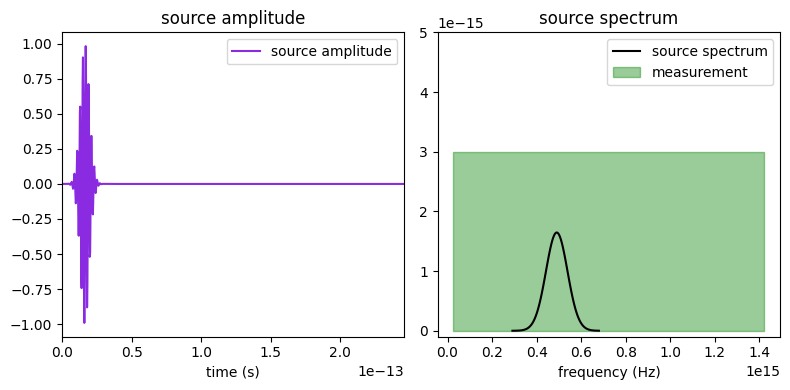

In [9]:
times = np.arange(0, sim.run_time, sim.dt)
amps = np.real(sim.sources[0].source_time.amp_time(times))
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim.sources[1].source_time.plot(times=np.linspace(0, sim.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim.run_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[1].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001), val='abs', ax=ax2)
fill_max = 30e-16 # 10e-16
ymax = 50e-16 # 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [10]:
sim_data = web.run(sim, task_name='rand_dipole_data', path=f'data/r_dipole_data_vac.hdf5', verbose=True)

             Created task 'rand_dipole_data' with task_id                       
             'fdve-a6a93641-2969-4179-b356-100e78620a7a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=851103;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=420855;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\taskId]8;;\]8;id=851103;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\=]8;;\]8;id=513217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\fdve]8;;\]8;id=851103;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\-a6a93641-296]8;;\
             ]8;id=851103;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\9-4179-b356-100e78620a7a']8;;\.

             Task folder: ]8;id=188319;https://tidy3d.simulation.cloud/folders/folder-6a4a7e17-1755-4d0e-b9e8-852e778c3971\'default']8;;\.

Output()

14:23:31 UTC Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:23:32 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:23:46 UTC status = preprocess

14:24:08 UTC starting up solver

             running solver

Output()

Output()

14:24:19 UTC status = postprocess

14:24:41 UTC status = success

14:24:43 UTC View simulation result at                                          
             ]8;id=811827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=940000;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\taskId]8;;\]8;id=811827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\=]8;;\]8;id=769041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\fdve]8;;\]8;id=811827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\-a6a93641-296]8;;\
             ]8;id=811827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6a93641-2969-4179-b356-100e78620a7a\9-4179-b356-100e78620a7a']8;;\.

Output()

14:24:45 UTC loading simulation from data/r_dipole_data_vac.hdf5

14:24:46 UTC WARNING: Structure at structures[0] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 29 WARNING messages.                           

             WARNING: Simulation final field decay value of 0.425 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

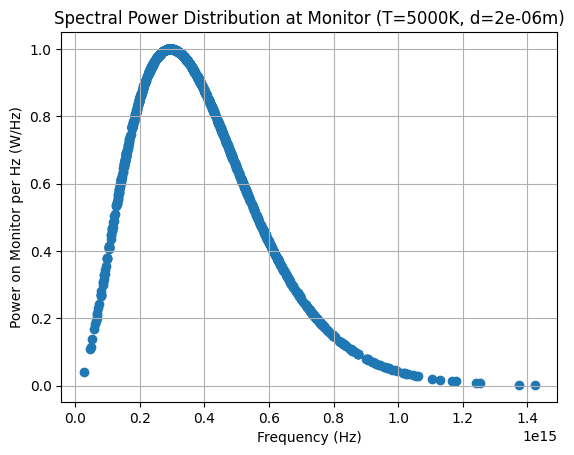

In [11]:
# === User Inputs ===
A_source = (Lx * Ly) * 10**(-6)

d = 2e-6  # Distance from source to monitor in meters
monitor_width = (Lx + 5)*10**(-6)  # Monitor width in meters (example: 20 cm)
monitor_height = (Ly + 5)*10**(-6)  # Monitor height in meters (example: 10 cm)
A_monitor = monitor_width * monitor_height  # Monitor area (m^2)

# === Physical Constants ===
h = 6.62607015e-34  # Planck constant (J·s)
c = 299792458       # Speed of light (m/s)
k_B = 1.380649e-23  # Boltzmann constant (J/K)

# === Frequency Grid ===
nu = freqs

# === Planck Law Computation ===
B_nu = (2 * h * nu**3 / c**2) / (np.exp(h * nu / (k_B * T)) - 1)  # Spectral radiance (W·m⁻²·sr⁻¹·Hz⁻¹)
M_nu = np.pi * B_nu  # Spectral exitance from source (W·m⁻²·Hz⁻¹)

# === Power Emitted by Source per Hz ===
P_nu_total = M_nu * A_source  # Total power per Hz emitted into hemisphere (W/Hz)

# === Flux at Monitor per Hz ===
F_nu_monitor = P_nu_total / (4 * np.pi * d**2)  # Inverse-square law (W·m⁻²·Hz⁻¹)

# === Power Received by Monitor per Hz ===
P_nu_monitor = F_nu_monitor * A_monitor  # (W/Hz)

plt.figure()
plt.scatter(nu, P_nu_monitor/max(P_nu_monitor))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power on Monitor per Hz (W/Hz)')
plt.title(f'Spectral Power Distribution at Monitor (T={T}K, d={d}m)')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Normalised Frequency distribution')

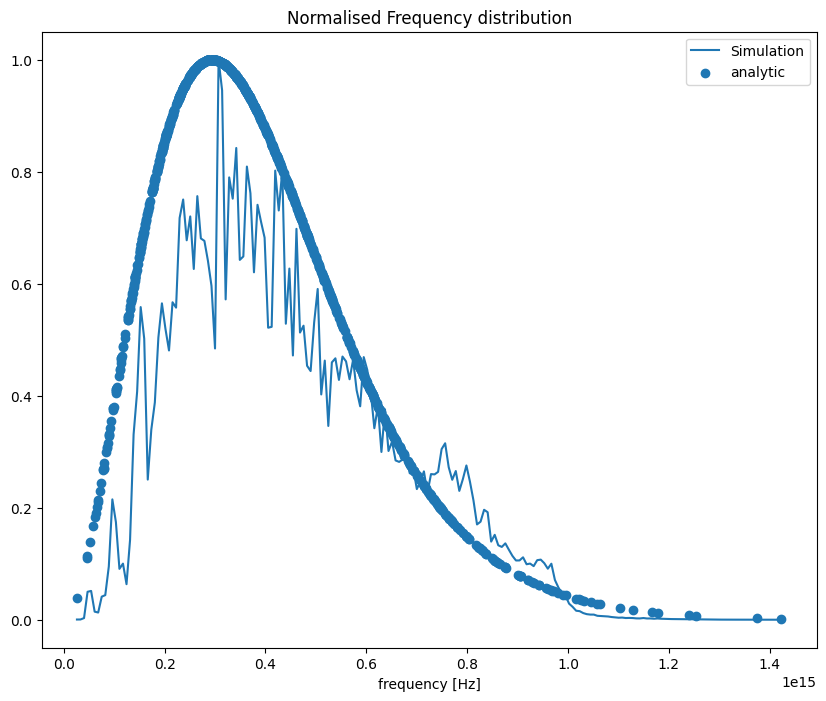

In [12]:
fig, ax1 = plt.subplots(figsize=(10,8))
transmission_far = sim_data['flux_far'].flux
transmission_far = transmission_far/max(transmission_far)
transmission_far.plot(ax=ax1, label="Simulation")
ax1.scatter(nu, P_nu_monitor/max(P_nu_monitor),label='analytic')
ax1.legend()
ax1.set_title('Normalised Frequency distribution')

Text(0.5, 1.0, 'raw transmission')

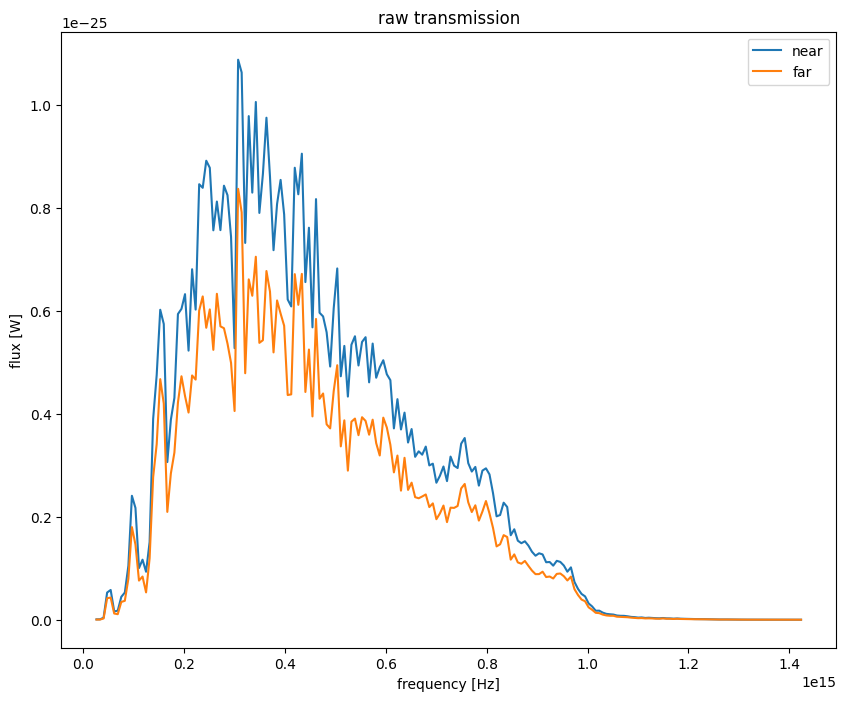

In [13]:
fig, ax1 = plt.subplots(figsize=(10,8))
transmission_near = sim_data['flux_near'].flux
transmission_near.plot(ax=ax1, label="near")
transmission_far = sim_data['flux_far'].flux
transmission_far.plot(ax=ax1, label="far")
ax1.legend()
ax1.set_title('raw transmission')

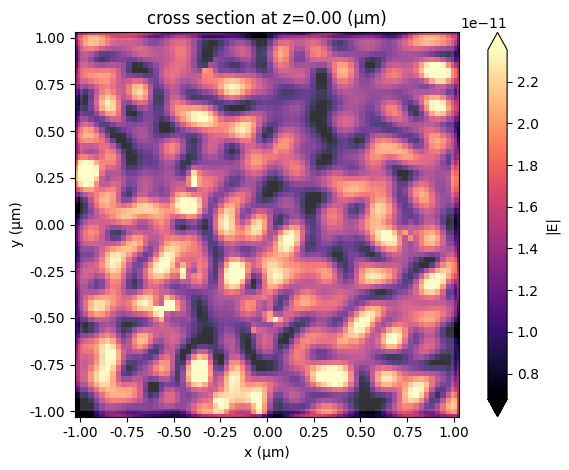

In [14]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs", z=0)
plt.show()

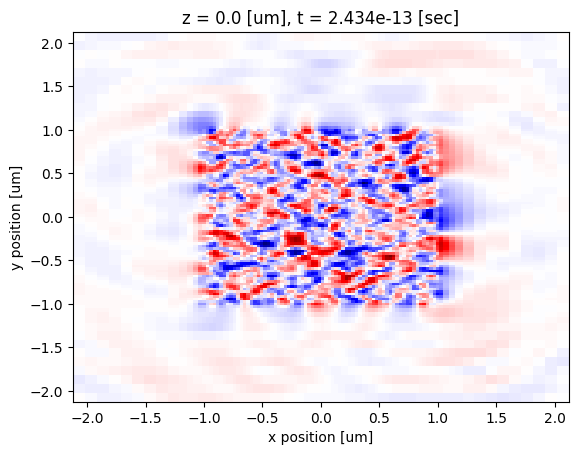

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

t_end = sim_data["movie_monitor"].Ex.coords["t"][-1]  # end time of the animation
frames = 100  # number of frames

plt.rcParams['animation.html'] = 'jshtml'

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    t = t_end * i / frames
    da = sim_data["movie_monitor"].Ex.sel(t=t, method="nearest")
    im = da.plot(x="x", y="y",
                 ax=ax,
                 add_colorbar=False,
                 cmap="seismic")
    return im,

ani = animation.FuncAnimation(
    fig,
    animate,
    frames=frames,
    blit=True,
    interval=100
)

# 2) Save to MP4:
ani.save('field_evolution.mp4',
         writer='ffmpeg',   # use 'imagemagick' if you prefer a GIF
         fps=10,            # frames per second
         dpi=200)           # resolution control